# Conditional Autoencoder for Asset Pricing - Part 2: The Model

This notebook uses a dataset created using `yfinance` in the notebook [conditional_autoencoder_for_asset_pricing_data](05_conditional_autoencoder_for_asset_pricing_data.ipynb). The results will vary depending on which ticker downloads succeeded.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys, os
from time import time
from pathlib import Path
from itertools import product
from tqdm import tqdm 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dot, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard

from sklearn.preprocessing import quantile_transform

from scipy.stats import spearmanr

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [5]:
idx = pd.IndexSlice
sns.set_style('whitegrid')
np.random.seed(42)

In [6]:
results_path = Path('results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [7]:
characteristics = ['beta', 'betasq', 'chmom', 'dolvol', 'idiovol', 'ill', 'indmom',
                   'maxret', 'mom12m', 'mom1m', 'mom36m', 'mvel', 'retvol', 'turn', 'turn_std']

## Load Data

In [8]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: results/asset_pricing/autoencoder.h5
/close                      frame        (shape->[7559,4420])
/factor/beta                frame        (shape->[2969406,1])
/factor/betasq              frame        (shape->[2969406,1])
/factor/chmom               frame        (shape->[3375489,1])
/factor/dolvol              frame        (shape->[3534960,1])
/factor/idiovol             frame        (shape->[2969406,1])
/factor/ill                 frame        (shape->[3210773,1])
/factor/indmom              frame        (shape->[3551199,1])
/factor/maxret              frame        (shape->[3562402,1])
/factor/mom12m              frame        (shape->[3375489,1])
/factor/mom1m               series       (shape->[3580621])  
/factor/mom36m              frame        (shape->[2967391,1])
/factor/mvel                frame        (shape->[3597636,1])
/factor/retvol              frame        (shape->[3580621,1])
/factor/turn                frame        (shap

### Weekly returns

In [20]:
data = (pd.read_hdf(results_path / 'autoencoder.h5', 'returns')
        .stack(dropna=False)
        .to_frame('returns')
        .loc[idx['1993':, :], :])

In [22]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    keys = [k[1:] for k in store.keys() if k[1:].startswith('factor')]
    for key in keys:
        data[key.split('/')[-1]] = store[key].squeeze()

In [23]:
characteristics = data.drop('returns', axis=1).columns.tolist()

In [24]:
data['returns_fwd'] = data.returns.unstack('ticker').shift(-1).stack()

In [25]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6232200 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'A') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 17 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   returns      3452579 non-null  float64
 1   beta         2969406 non-null  float64
 2   betasq       2969406 non-null  float64
 3   chmom        3283334 non-null  float64
 4   dolvol       3403423 non-null  float64
 5   idiovol      2969406 non-null  float64
 6   ill          3108429 non-null  float64
 7   indmom       3452527 non-null  float64
 8   maxret       3426881 non-null  float64
 9   mom12m       3283334 non-null  float64
 10  mom1m        3440945 non-null  float64
 11  mom36m       2967391 non-null  float64
 12  mvel         3454030 non-null  float64
 13  retvol       3440945 non-null  float64
 14  turn         3380001 non-null  float64
 15  turn_std     3413256 non-null  fl

In [14]:
nobs_by_date = data.groupby(level='date').count().max(1)
nobs_by_characteristic = pd.melt(data[characteristics].groupby(level='date').count(),
                                 value_name='# Observations',
                                 var_name=['Characteristic'])

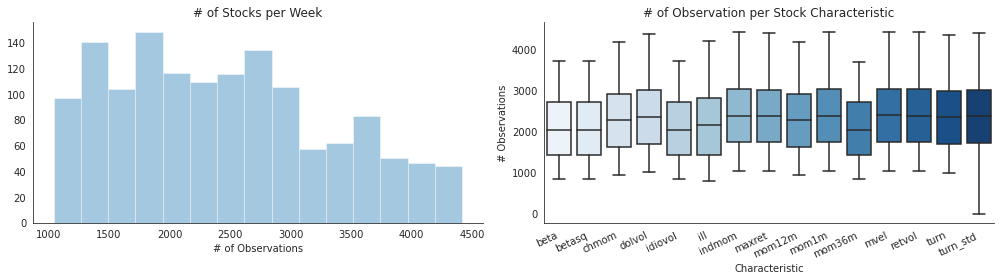

In [15]:
with sns.axes_style("white"):
    fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
    sns.distplot(nobs_by_date, kde=False, ax=axes[0])
    axes[0].set_title('# of Stocks per Week')
    axes[0].set_xlabel('# of Observations')
    sns.boxplot(x='Characteristic',
                y='# Observations',
                data=nobs_by_characteristic,
                ax=axes[1],
                palette='Blues')
    axes[1].set_xticklabels(axes[1].get_xticklabels(),
                            rotation=25,
                            ha='right')
    axes[1].set_title('# of Observation per Stock Characteristic')
    sns.despine()
    fig.tight_layout()

### Rank-normalize characteristics

In [16]:
data.loc[:, characteristics] = (data.loc[:, characteristics]
                                .groupby(level='date')
                                .apply(lambda x: pd.DataFrame(quantile_transform(x, 
                                                                                 copy=True, 
                                                                                 n_quantiles=x.shape[0]),
                                                              columns=characteristics,
                                                              index=x.index.get_level_values('ticker')))
                               .mul(2).sub(1))

In [17]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6232200 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'A') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 17 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   returns      3452579 non-null  float64
 1   beta         2969406 non-null  float64
 2   betasq       2969406 non-null  float64
 3   chmom        3283334 non-null  float64
 4   dolvol       3403423 non-null  float64
 5   idiovol      2969406 non-null  float64
 6   ill          3108429 non-null  float64
 7   indmom       3452527 non-null  float64
 8   maxret       3426881 non-null  float64
 9   mom12m       3283334 non-null  float64
 10  mom1m        3440945 non-null  float64
 11  mom36m       2967391 non-null  float64
 12  mvel         3454030 non-null  float64
 13  retvol       3440945 non-null  float64
 14  turn         3380001 non-null  float64
 15  turn_std     3413256 non-null  fl

In [18]:
data.index.names

FrozenList(['date', 'ticker'])

In [19]:
data.describe()

,returns,beta,betasq,chmom,dolvol,idiovol,ill,indmom,maxret,mom12m,mom1m,mom36m,mvel,retvol,turn,turn_std,returns_fwd
count,3.452579e+06,2.969406e+06,2.969406e+06,3.283334e+06,3.403423e+06,2.969406e+06,3.108429e+06,3.452527e+06,3.426881e+06,3.283334e+06,3.440945e+06,2.967391e+06,3.454030e+06,3.440945e+06,3.380001e+06,3.413256e+06,3.451536e+06
mean,3.011444e-03,-4.514118e-09,-3.661858e-07,-4.961806e-08,-8.404166e-07,-9.121839e-08,-4.094780e-07,1.003525e-03,-7.020948e-08,-1.223854e-07,-2.300930e-08,-1.665202e-07,-2.744138e-08,-1.153290e-06,-3.940610e-07,-1.342879e-06,3.008981e-03
std,6.176189e-02,5.776241e-01,5.776246e-01,5.775977e-01,5.775907e-01,5.776242e-01,5.776119e-01,5.859634e-01,5.775870e-01,5.775978e-01,5.775841e-01,5.776243e-01,5.775857e-01,5.775884e-01,5.775911e-01,5.775899e-01,6.176569e-02
min,-9.269350e-01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-9.269350e-01
25%,-2.151944e-02,-5.002862e-01,-5.002779e-01,-5.002653e-01,-5.002520e-01,-5.002830e-01,-5.002665e-01,-4.969450e-01,-5.002388e-01,-5.002763e-01,-5.002454e-01,-5.002837e-01,-5.002486e-01,-5.002370e-01,-5.002599e-01,-5.002387e-01,-2.152460e-02
50%,9.756321e-04,4.103460e-06,3.428143e-06,5.635024e-06,-6.761061e-06,-5.194775e-06,7.698840e-06,0.000000e+00,8.172791e-06,6.175095e-06,-1.165672e-04,-7.247569e-06,2.850846e-06,-2.794473e-06,1.038184e-05,2.845388e-06,9.756585e-04
75%,2.491691e-02,5.002871e-01,5.002862e-01,5.002657e-01,5.002522e-01,5.002879e-01,5.002743e-01,4.774836e-01,5.002266e-01,5.002604e-01,5.002571e-01,5.002797e-01,5.002506e-01,5.002554e-01,5.002418e-01,5.002498e-01,2.491509e-02
max,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00


In [20]:
data = data.loc[idx[:'2019', :], :]

In [21]:
data.loc[:, ['returns', 'returns_fwd']] = data.loc[:, ['returns', 'returns_fwd']].clip(lower=-1, upper=1.0)

In [22]:
data = data.fillna(-2)

In [23]:
data.to_hdf(results_path / 'autoencoder.h5', 'model_data')

## Architecture

In [8]:
data = pd.read_hdf(results_path / 'autoencoder.h5', 'model_data')

### Key parameters

In [9]:
n_factors = 3
n_characteristics = len(characteristics)
n_tickers = len(data.index.unique('ticker'))

In [10]:
n_tickers

4420

In [11]:
n_characteristics

15

### Input Layer

In [28]:
input_beta = Input((n_tickers, n_characteristics), name='input_beta')
input_factor = Input((n_tickers,), name='input_factor')

### Stock Characteristics Network

In [29]:
hidden_layer = Dense(units=8, activation='relu', name='hidden_layer')(input_beta)
batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

### Factor Network

In [30]:
output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

### Output Layer

In [31]:
output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

### Compile Layer

In [32]:
model = Model(inputs=[input_beta, input_factor], outputs=output)
model.compile(loss='mse', optimizer='adam')

### Automate model generation

In [12]:
def make_model(hidden_units=8, n_factors=3):
    input_beta = Input((n_tickers, n_characteristics), name='input_beta')
    input_factor = Input((n_tickers,), name='input_factor')

    hidden_layer = Dense(units=hidden_units, activation='relu', name='hidden_layer')(input_beta)
    batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
    
    output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

    output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

    output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

    model = Model(inputs=[input_beta, input_factor], outputs=output)
    model.compile(loss='mse', optimizer='adam')
    return model

### Model Summary

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_beta (InputLayer)         [(None, 4420, 15)]   0                                            
__________________________________________________________________________________________________
hidden_layer (Dense)            (None, 4420, 8)      128         input_beta[0][0]                 
__________________________________________________________________________________________________
batch_norm (BatchNormalization) (None, 4420, 8)      32          hidden_layer[0][0]               
__________________________________________________________________________________________________
input_factor (InputLayer)       [(None, 4420)]       0                                            
______________________________________________________________________________________________

## Train Model

### Cross-validation parameters

In [13]:
YEAR = 52

In [14]:
cv = MultipleTimeSeriesCV(n_splits=5, 
                          train_period_length=20*YEAR,
                          test_period_length=1*YEAR,
                          lookahead=1)

In [15]:
def get_train_valid_data(data, train_idx, val_idx):
    train, val = data.iloc[train_idx], data.iloc[val_idx]
    X1_train = train.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X1_val = val.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X2_train = train.loc[:, 'returns'].unstack('ticker')
    X2_val = val.loc[:, 'returns'].unstack('ticker')
    y_train = train.returns_fwd.unstack('ticker')
    y_val = val.returns_fwd.unstack('ticker')
    return X1_train, X2_train, y_train, X1_val, X2_val, y_val

### Hyperparameter Options

In [16]:
factor_opts = [2, 3, 4, 5, 6]
unit_opts = [8, 16, 32]

In [17]:
param_grid = list(product(unit_opts, factor_opts))

### Run Cross-Validation

In [40]:
batch_size = 32

In [41]:
cols = ['units', 'n_factors', 'fold', 'epoch', 'ic_mean', 
        'ic_daily_mean', 'ic_daily_std', 'ic_daily_median']

In [42]:
start = time()
for units, n_factors in param_grid:
    scores = []
    model = make_model(hidden_units=units, n_factors=n_factors)
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                                  train_idx,
                                                                                  val_idx)
        for epoch in range(250):
            model.fit([X1_train, X2_train], y_train,
                      batch_size=batch_size,
                      validation_data=([X1_val, X2_val], y_val),
                      epochs=epoch + 1,
                      initial_epoch=epoch,
                      verbose=0, shuffle=True)
            result = (pd.DataFrame({'y_pred': model.predict([X1_val,
                                                             X2_val]).reshape(-1),
                                    'y_true': y_val.stack().values},
                                   index=y_val.stack().index)
                      .replace(-2, np.nan).dropna())
            r0 = spearmanr(result.y_true, result.y_pred)[0]
            r1 = result.groupby(level='date').apply(lambda x: spearmanr(x.y_pred,
                                                                        x.y_true)[0])

            scores.append([units, n_factors, fold, epoch, r0,
                           r1.mean(), r1.std(), r1.median()])
            if epoch % 50 == 0:
                print(f'{format_time(time()-start)} | {n_factors} | {units:02} | {fold:02}-{epoch:03} | {r0:6.2%} | '
                  f'{r1.mean():6.2%} | {r1.median():6.2%}')            
    scores = pd.DataFrame(scores, columns=cols)
    scores.to_hdf(results_path / 'scores.h5', f'{units}/{n_factors}')

00:00:03 | 2 08 | 00-000 |  1.24% |  0.24% | -0.25%
00:00:32 | 2 08 | 00-050 | -0.26% | -0.38% |  0.10%
00:01:01 | 2 08 | 00-100 | -1.46% |  0.22% | -0.62%
00:01:30 | 2 08 | 00-150 | -2.23% | -0.19% | -0.46%
00:02:00 | 2 08 | 00-200 | -3.28% |  0.42% | -1.34%
00:02:31 | 2 08 | 01-000 | -1.09% |  1.13% |  1.28%
00:03:01 | 2 08 | 01-050 |  0.19% |  1.12% |  1.57%
00:03:31 | 2 08 | 01-100 |  0.16% | -1.05% | -2.39%
00:04:00 | 2 08 | 01-150 |  0.82% |  0.28% | -0.02%
00:04:31 | 2 08 | 01-200 |  1.13% |  0.06% |  0.22%
00:05:01 | 2 08 | 02-000 | -0.21% | -0.34% | -0.56%
00:05:30 | 2 08 | 02-050 |  0.14% | -0.09% |  0.25%
00:05:59 | 2 08 | 02-100 |  1.96% |  0.99% |  2.66%
00:06:26 | 2 08 | 02-150 |  0.96% | -0.08% | -0.98%
00:06:55 | 2 08 | 02-200 |  0.87% |  0.19% |  1.90%
00:07:25 | 2 08 | 03-000 |  0.75% | -0.15% |  1.57%
00:07:53 | 2 08 | 03-050 |  1.59% |  1.50% |  2.23%
00:08:22 | 2 08 | 03-100 |  0.42% |  0.75% | -0.60%
00:08:51 | 2 08 | 03-150 | -1.20% | -1.20% | -1.41%
00:09:19 | 2

01:10:55 | 3 16 | 01-150 | -1.81% | -0.54% | -1.85%
01:11:21 | 3 16 | 01-200 |  1.01% |  0.87% |  0.37%
01:11:47 | 3 16 | 02-000 |  1.36% |  1.28% |  1.63%
01:12:11 | 3 16 | 02-050 | -0.43% | -0.41% |  0.44%
01:12:36 | 3 16 | 02-100 |  1.22% |  0.97% |  2.21%
01:13:02 | 3 16 | 02-150 | -0.32% |  0.22% | -0.21%
01:13:28 | 3 16 | 02-200 |  1.78% |  1.42% |  2.20%
01:13:54 | 3 16 | 03-000 | -0.45% |  0.11% |  0.31%
01:14:20 | 3 16 | 03-050 |  1.84% |  1.43% |  0.68%
01:14:45 | 3 16 | 03-100 |  1.91% |  0.82% |  2.21%
01:15:10 | 3 16 | 03-150 |  1.30% |  1.01% |  1.47%
01:15:36 | 3 16 | 03-200 | -0.58% | -0.00% |  0.59%
01:16:04 | 3 16 | 04-000 | -1.66% | -1.20% | -2.58%
01:16:31 | 3 16 | 04-050 |  0.63% |  1.13% |  1.47%
01:16:59 | 3 16 | 04-100 | -2.45% |  0.45% |  0.75%
01:17:24 | 3 16 | 04-150 |  0.42% |  0.96% | -0.03%
01:17:49 | 3 16 | 04-200 | -0.09% |  0.22% |  0.55%
01:18:18 | 4 16 | 00-000 |  0.68% | -0.68% | -0.80%
01:18:44 | 4 16 | 00-050 |  1.10% |  0.53% |  0.15%
01:19:11 | 4

02:19:33 | 4 32 | 03-050 |  0.95% |  0.68% |  1.37%
02:19:59 | 4 32 | 03-100 | -0.66% | -0.18% | -1.67%
02:20:26 | 4 32 | 03-150 |  1.85% |  1.16% |  2.21%
02:20:53 | 4 32 | 03-200 | -0.52% |  0.35% |  0.30%
02:21:21 | 4 32 | 04-000 |  5.03% |  2.61% |  0.80%
02:21:49 | 4 32 | 04-050 |  0.61% | -0.71% |  1.09%
02:22:17 | 4 32 | 04-100 |  5.45% |  4.32% |  3.05%
02:22:43 | 4 32 | 04-150 |  1.40% |  3.85% |  3.64%
02:23:11 | 4 32 | 04-200 | -4.90% | -2.73% | -2.85%
02:23:42 | 5 32 | 00-000 | -2.62% | -2.92% | -3.29%
02:24:13 | 5 32 | 00-050 |  1.15% | -0.38% | -1.95%
02:24:44 | 5 32 | 00-100 |  0.85% | -0.85% | -1.90%
02:25:10 | 5 32 | 00-150 |  0.69% | -0.97% | -1.53%
02:25:38 | 5 32 | 00-200 | -0.01% | -1.20% | -1.89%
02:26:09 | 5 32 | 01-000 |  0.18% |  0.27% |  0.69%
02:26:35 | 5 32 | 01-050 | -0.01% | -0.29% |  0.40%
02:27:01 | 5 32 | 01-100 |  0.57% |  0.25% |  0.96%
02:27:29 | 5 32 | 01-150 | -0.22% | -0.05% | -1.12%
02:27:57 | 5 32 | 01-200 | -0.71% | -0.35% | -2.00%
02:28:27 | 5

### Evaluate Results

In [13]:
scores = []
with pd.HDFStore(results_path / 'scores.h5') as store:
    for key in store.keys():
        scores.append(store[key])
scores = pd.concat(scores)

In [14]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18750 entries, 0 to 1249
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   units            18750 non-null  int64  
 1   n_factors        18750 non-null  int64  
 2   fold             18750 non-null  int64  
 3   epoch            18750 non-null  int64  
 4   ic_mean          18750 non-null  float64
 5   ic_daily_mean    18750 non-null  float64
 6   ic_daily_std     18750 non-null  float64
 7   ic_daily_median  18750 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 1.3 MB


In [15]:
avg = (scores.groupby(['n_factors', 'units', 'epoch'])
       ['ic_mean', 'ic_daily_mean', 'ic_daily_median']
       .mean()
      .reset_index())

In [16]:
avg.nlargest(n=20, columns=['ic_daily_median'])

,n_factors,units,epoch,ic_mean,ic_daily_mean,ic_daily_median
2079,4,32,79,0.026611,0.023304,0.028009
2218,4,32,218,0.019487,0.015941,0.027230
2052,4,32,52,0.023268,0.019379,0.027194
1681,4,8,181,0.056288,0.015536,0.027112
2234,4,32,234,0.026894,0.016454,0.026352
1614,4,8,114,0.037274,0.018129,0.025588
1608,4,8,108,0.030997,0.019158,0.025526
765,3,8,15,0.015636,0.014492,0.024900
1716,4,8,216,0.003554,0.016880,0.024367
1712,4,8,212,0.020408,0.019991,0.024052


In [17]:
top = (avg.groupby(['n_factors', 'units'])
       .apply(lambda x: x.nlargest(n=5, columns=['ic_daily_median']))
       .reset_index(-1, drop=True))

top.nlargest(n=5, columns=['ic_daily_median'])

n_factors  units  epoch   ic_mean  ic_daily_mean  \
n_factors units                                                     
4         32             4     32     79  0.026611       0.023304   
          32             4     32    218  0.019487       0.015941   
          32             4     32     52  0.023268       0.019379   
          8              4      8    181  0.056288       0.015536   
          32             4     32    234  0.026894       0.016454   

                 ic_daily_median  
n_factors units                   
4         32            0.028009  
          32            0.027230  
          32            0.027194  
          8             0.027112  
          32            0.026352

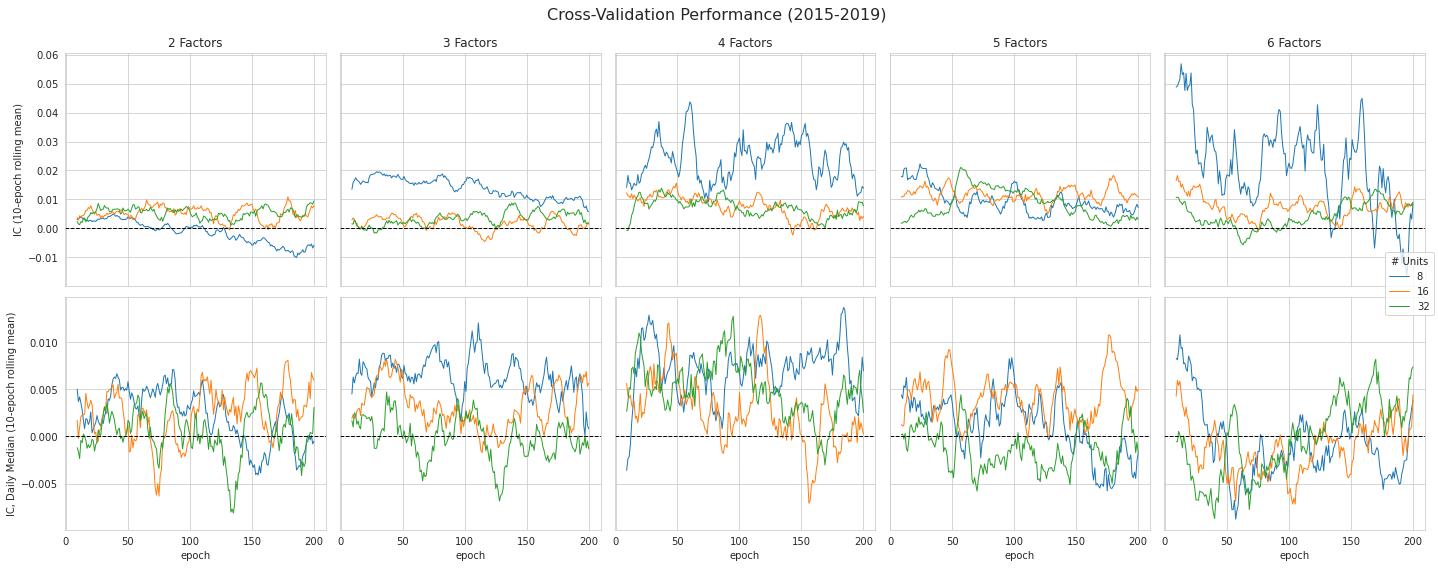

In [48]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 8), sharey='row', sharex=True)

for n in range(2, 7):
    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_mean')
    df.rolling(10).mean().loc[:200].plot(ax=axes[0][n-2], lw=1, title=f'{n} Factors')
    axes[0][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[0][n-2].get_legend().remove()
    axes[0][n-2].set_ylabel('IC (10-epoch rolling mean)')

    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_daily_median')
    df.rolling(10).mean().loc[:200].plot(ax=axes[1][n-2], lw=1)
    axes[1][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[1][n-2].get_legend().remove()
    axes[1][n-2].set_ylabel('IC, Daily Median (10-epoch rolling mean)')

handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='# Units')
fig.suptitle('Cross-Validation Performance (2015-2019)', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'cv_performance', dpi=300);

## Generate Predictions

We'll average over a range of epochs that appears to deliver good predictions.

In [18]:
n_factors = 4
units = 32
batch_size = 32
first_epoch = 50
last_epoch = 80

In [19]:
predictions = []
for epoch in tqdm(list(range(first_epoch, last_epoch))):
    epoch_preds = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                                  train_idx,
                                                                                  val_idx)

        model = make_model(n_factors=n_factors, hidden_units=units)
        model.fit([X1_train, X2_train], y_train,
                  batch_size=batch_size,
                  epochs=epoch,
                  verbose=0,
                  shuffle=True)
        epoch_preds.append(pd.Series(model.predict([X1_val, X2_val]).reshape(-1),
                                     index=y_val.stack().index).to_frame(epoch))

    predictions.append(pd.concat(epoch_preds))

100%|██████████| 30/30 [32:27<00:00, 64.92s/it]


In [51]:
predictions_combined = pd.concat(predictions, axis=1).sort_index()   

In [52]:
predictions_combined.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1149200 entries, (Timestamp('2015-01-09 00:00:00'), 'A') to (Timestamp('2019-12-27 00:00:00'), 'ZYXI')
Data columns (total 40 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   130     1149200 non-null  float32
 1   131     1149200 non-null  float32
 2   132     1149200 non-null  float32
 3   133     1149200 non-null  float32
 4   134     1149200 non-null  float32
 5   135     1149200 non-null  float32
 6   136     1149200 non-null  float32
 7   137     1149200 non-null  float32
 8   138     1149200 non-null  float32
 9   139     1149200 non-null  float32
 10  140     1149200 non-null  float32
 11  141     1149200 non-null  float32
 12  142     1149200 non-null  float32
 13  143     1149200 non-null  float32
 14  144     1149200 non-null  float32
 15  145     1149200 non-null  float32
 16  146     1149200 non-null  float32
 17  147     1149200 non-null  float32
 18  148     1149200 non-null  flo

In [53]:
predictions_combined.to_hdf(results_path / 'predictions.h5', 'predictions')